In [1]:
import os.path
import numpy as np
import pandas as pd
import torch
import pickle
import subprocess
from matplotlib import pyplot as plt
from Bio import SeqIO
from importlib import reload
import warnings

from scipy.stats import mode
from sklearn.neighbors import KernelDensity
from skimage.graph import route_through_array
from scipy.spatial import cKDTree

import matplotlib.cm as cm

import minimal_version.parser_handler
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/
from minimal_version.preprocess_msa import Preprocessor, weight_sequences
from minimal_version.msa import MSA
from minimal_version.utils import Capturing, store_to_pkl, store_to_fasta, load_from_pkl

from minimal_version.train import setup_train, Train

%cd /Users/dahala/GitHub/VAE-enzymes/
from custom_functions import *
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/



/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


## VAE Visualization

In [2]:
CONFIGURATION_FILE = "msaEnzymeMiner_TRPase_trim_400_600.json"
run = minimal_version.parser_handler.RunSetup(CONFIGURATION_FILE)
print(f" Working with {CONFIGURATION_FILE} configuration file!")
PFAM_INPUT = False

Configuration file stored in ../results/EnzymeMiner_TRPase_trim_400_600/config/2025-09-07_12-05.json
 Working with msaEnzymeMiner_TRPase_trim_400_600.json configuration file!


In [3]:
'''
HMMbuild = HMMmodule(run)
#HMMbuild.MSA_create()
HMMbuild.build()
HMMbuild.align('Trim_400_600',fasta_ext='fasta')
'''

"\nHMMbuild = HMMmodule(run)\n#HMMbuild.MSA_create()\nHMMbuild.build()\nHMMbuild.align('Trim_400_600',fasta_ext='fasta')\n"

In [4]:
"""
Preprocess MSA and prepare it for VAE model training
"""

# logging
msa_log = open(os.path.join(run.logs, 'msa_log.txt'), "w")

# MSA loading
if PFAM_INPUT:
    msa = MSA.load_pfam(run.dataset)
else:
    msa = MSA.load_msa(run.dataset)
MSA.amino_acid_dict(run.pickles)
msg = f"MSA in {run.dataset} loaded\n" \
      f"number of sequences: {len(list(msa.keys()))}"
print(msg)
msa_log.write(msg + f'\n{"="*80}\n')

# MSA preprocessing
preprocessor = Preprocessor(run)
with Capturing() as output:
    msa, msa_keys = preprocessor.trim_msa(msa)
msa_log.write(" MSA Preprocessing \n" + "\n".join(output) + f'\n{"="*80}\n')
assert (msa.shape[0] == len(msa_keys))
trim_file_path = os.path.join(run.msa, "trimmed_msa.fasta")
msg = f"Trimmed MSA has {msa.shape[0]} sequences and the width is {msa.shape[1]}\n" \
      f"Trimmed MSA is stored at {trim_file_path}"
print(msg)
msa_log.write(msg + f'\n{"="*80}\n')
msa_num_dict_shuffled = {k: seq for k, seq in zip(msa_keys, msa)}  # transform to dictionary, have keys together
# but secure that query and fixed sequences are at the beginning 
msa_num_dict = {k: msa_num_dict_shuffled[k] for k in preprocessor.keep_keys}
msa_num_dict.update({k: msa_num_dict_shuffled[k] for k in msa_num_dict_shuffled if k not in preprocessor.keep_keys})

trimmed_msa = MSA.number_to_amino(msa_num_dict)
store_to_fasta(trimmed_msa, trim_file_path)
store_to_pkl({run.query: trimmed_msa[run.query]}, os.path.join(run.pickles, "reference_seq.pkl"))

# Filtering or weighting
with Capturing() as output:
    if run.clustering:  # MSA filtering
        print(f"MSA {run.identity}% identity filtering step")
        msa_num_dict = preprocessor.identity_filtering(msa_num_dict)
        msa, training_alg = preprocessor.get_keys_file_and_np_sequences(msa_num_dict)  # Overlap one treemmer
        seq_weight = np.ones(msa.shape[0])  # we just provide uniform weights for all sequences
    else:  # otherwise the weighting mechanism will be applied
        msa, training_alg = preprocessor.get_keys_file_and_np_sequences(msa_num_dict)  # Overlap one treemmer
        seq_weight = weight_sequences(msa)
msa_log.write("\n".join(output))
train_msa_file_path = os.path.join(run.msa, "training_msa.fasta")
training_alg = MSA.number_to_amino(training_alg)
store_to_fasta(training_alg, train_msa_file_path)
msg = f"Training MSA has {msa.shape[0]} sequences and the width is {msa.shape[1]}\n" \
      f"Training MSA is stored at {train_msa_file_path}"
print(msg)
msa_log.write(msg + f'\n{"=" * 80}\n')

store_to_pkl(seq_weight, os.path.join(run.pickles, "seq_weight.pkl"))
store_to_pkl(training_alg, os.path.join(run.pickles, "training_alignment.pkl"))

# MSA one-hot encoding
binary = MSA.number_to_binary(msa)
store_to_pkl(binary, os.path.join(run.pickles, "seq_msa_binary.pkl"))
msa_log.close()

MSA in ../datasets/EnzymeMiner_TRPase_trim_400_600_fix.afa loaded
number of sequences: 5852
Trimmed MSA has 5852 sequences and the width is 455
Trimmed MSA is stored at ../results/EnzymeMiner_TRPase_trim_400_600/msa/trimmed_msa.fasta
Training MSA has 5852 sequences and the width is 455
Training MSA is stored at ../results/EnzymeMiner_TRPase_trim_400_600/msa/training_msa.fasta


In [5]:
with open(run.pickles+ "/msa_columns.pkl", "rb") as input_file:
   msa_columns = pickle.load(input_file)

In [6]:

load_from_pkl(os.path.join(run.model, "model_params.pkl"))['model']

'vae'

In [ ]:
exp_res = pd.read_csv('../../random_data/TRPase/Cleaned_Experimental_Data.csv',index_col=0).iloc[:-5,:]
rel_act = pd.read_excel('../../random_data/TRPase/20250328_TRPase_rel_act.xlsx', sheet_name='Sheet2',index_col=1)
rel_act = rel_act.loc[exp_res.index]

In [ ]:
test_1 = 'MKYPAEPFKIKMIEPLRLISREERITALKEAGYNPFSLRAEDVYIDLLTDSGTGAMSDRQWAGLMQGDESYAGSRSFYHLQDSVRDVIGYSYVVPTHQGRGAEQVLFPLLIKPGQSVISNWHFDTTRVHVELAGGKAIDLVTDEALDTNTYHAFKGNIDIEKARKVIEETGKENIALLIITITNNSAGGQPVSMENIKQASALAKEYGLRFLLDAARFSENAYFIKQREAGYQQKSIRQIVREMFTYADAFTMSAKKDGLVNIGGLIGIREKQELYEQIRSAVVPLEGFPTYGGLAGRDMEALAAGLQEVVEEEYLHYRIAQIAYLGDRLVAGGIPIQTPTGGHAVFVDAKKMLSHIPFDQFPGQVLANELYVESGVRAVEVGSLLLGRDPKTNQQLVSPLELLRLTIPRRVYTYAHMDVIADGLIRIKERAHELRGLTFTYEPPMLRHFTARLKPVEEK'
test_2 = 'MAKRIVEPFRIKMVEKIRVPSREEREAALKEAGYNPFLLPSSAVYIDLLTDSGTNAMSDHQWAAMITGDEAYAGSRNYYDLKDKAKELFNYDYIIPAHQGRGAENILFPVLLKYKQKEGKAKNPVFISNFHFDTTAAHVELNGCKAINIVTEKAFDSETYDDWKGDFDIKKLKENIAQHGADNIVAIVSTVTCNSAGGQPVSMSNLKEVYEIAKQHGIFVVMDSARFCENAYFIKERDPKYKNATIKEVIFDMYKYADALTMSAKKDPLLNIGGLVAIRDNEEIFTLARQRCVPMEGFVTYGGLAGRDMAAMVQGLEEGTEEEYLHYRIGQVKYLGDRLREAGIPIQYPTGGHAVFVDCKKLVPQIPGDQFPAQAVINALYLESGVRAVEIGSFLLGRDPATGEQKHADMEFMRLTIARRVYTNDHMDYIADALIGLKEKFATLKGLEFEYEPPVLRHFTARLKPIE'

In [ ]:
arch_POI=['RMG28746.1','RLE90674.1']
euka_POI=['XP_015776371.1','BAN40838.1',
     'ORY78773.1','PRD32036.1','RBR22522.1',
     'WP_071313236.1',]
bact_POI=['WP_019211973.1','AAB24234.1','WP_108870457.1',
     'WP_104148942.1','WP_101260018.1',
     'WP_092012008.1','WP_109407456.1','WP_012992776.1',
     'WP_131680130.1','WP_001295247.1','C3LUI5_S1']

POI=['WP_104148942.1','WP_129037438.1']

POI_all = arch_POI + euka_POI + bact_POI

#,'WP_129037438.1'

In [231]:
panel = pd.read_csv('../../random_data/TRPase/enzyme_panel.csv', sep='\t')
name_converter = pd.read_csv('../../random_data/TRPase/TRPase_name_converter.csv',index_col=0)
panel['ID_VAE'] = panel['Abbreviation'].apply(lambda x: name_converter.loc[x,'Uniprot_ID'])

In [232]:
panel

,Origin,Domain,Abbreviation,Mass,ID,ID_VAE
0,Euryarchaeota archaeon,Archaea,EarTIL,53467.31,RMG28746.1,RMG28746.1
1,Thermoprotei archaeon,Archaea,TarTIL,53922.32,RLE90674.1,RLE90674.1
2,Acropora digitifera,Eukaryota,AdiTIL,61590.94,XP_015776371.1,XP_015776371.1
3,Entamoeba invadens,Eukaryota,EinTIL,60449.61,BAN40838.1,BAN40838.1
4,Neocallimastix californiae,Eukaryota,NcaTIL,57258.75,ORY78773.1,ORY78773.1
5,Trichonephila clavipes,Eukaryota,TclTIL,54551.26,PRD32036.1,PRD32036.1
6,Fusarium verticillioides,Eukaryota,FveTIL,61879.57,RBR22522.1,RBR22522.1
7,Anaerobacillus arseniciselenatis,Bacteria,AarTIL,57428.80,WP_071313236.1,WP_071313236.1
8,Yersinia massiliensis,Bacteria,YmaTIL,58859.01,WP_019211973.1,WP_019211973.1
9,Pantoea agglomerans,Bacteria,PagTIL,53805.26,AAB24234.1,AAB24234.1


In [220]:
msa = MSA.load_msa(run.dataset)
aln = SeqIO.to_dict(SeqIO.parse('/Users/dahala/GitHub/VAE-enzymes/random_data/TRPase/Trim_400_600.fasta', 'fasta'))

In [221]:
if os.path.exists(run.result+'/full_embedding.csv'):
    df_emb = pd.read_csv(run.result+'/full_embedding.csv', sep='\t')
else:
    print("Calculating embeddings...")

In [41]:
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig
from tqdm import tqdm
import sys
import os

if os.path.exists(run.result+'/full_embedding.csv'):
    df_emb = pd.read_csv(run.result+'/full_embedding.csv', sep='\t')

else:
    ESMC_model = 'esmc_600m' # Choose from 'esmc_300m', 'esmc_600m'
    pooling = 'mean'  # Choose from 'max', 'min', or 'mean'

    # Load the ESMC model
    client = ESMC.from_pretrained(ESMC_model).to("cpu")  # or "cuda"

    # Initialize an empty list to store the results
    results = []
    # Loop through the protein sequences
    for prot in tqdm(aln.keys()):#arch_POI+euka_POI+bact_POI:
        record = aln[prot]
        sequence = str(record.seq)  # Get the protein sequence
        protein = ESMProtein(sequence=sequence)  # Create an ESMProtein object

        # Encode the protein sequence
        protein_tensor = client.encode(protein)

        # Get the logits and embeddings
        logits_output = client.logits(
            protein_tensor, LogitsConfig(sequence=True, return_embeddings=True)
        )

        # Extract embeddings for the last layer (last element in the embeddings tensor)
        last_layer_embeddings = logits_output.embeddings[-1]  # Shape: (sequence_length, hidden_size)

        # Apply the chosen pooling method
        if pooling == 'mean':
            pooled_embedding = last_layer_embeddings.mean(dim=0).cpu().numpy()  # Mean pooling across sequence length
        elif pooling == 'min':
            pooled_embedding = last_layer_embeddings.min(dim=0)[0].cpu().numpy()  # Min pooling across sequence length
        elif pooling == 'max':
            pooled_embedding = last_layer_embeddings.max(dim=0)[0].cpu().numpy()  # Max pooling across sequence length
        else:
            print(f"Error: Unsupported pooling method '{pooling}'")
            sys.exit(1)

        # Initialize the row dictionary with the enzyme name (protein ID)
        row = {'enzyme': record.id}

        # Store the pooled embedding values as individual columns with numerical keys (0, 1, 2, ...)
        for dim in range(pooled_embedding.shape[0]):
            row[str(dim)] = float(pooled_embedding[dim])  # Ensure it is stored as a numeric value

        # Append the row to results
        results.append(row)

    # Convert the results list to a DataFrame
    df_emb = pd.DataFrame(results)

    # Ensure columns are in the correct order: 'enzyme' first, then the pooled embeddings
    cols = ['enzyme'] + [str(i) for i in range(pooled_embedding.shape[0])]
    df_emb = df_emb[cols]

    # Save the DataFrame to a CSV file with tab-separated values
    df_emb.to_csv(run.result+'/full_embedding.csv', index=False, sep='\t')  # Write the results to the output file

X_emb = df_emb.drop(columns=["enzyme"]).to_numpy()  # shape (20, 1152)

from sklearn.preprocessing import normalize

# X: numpy array of shape (N, d), from your df_emb.drop(columns=["enzyme"])
X_norm = normalize(X_emb)  # row-wise L2 normalization

Explained variance: [0.02707248 0.01420319 0.00379436 0.0027241  0.00157858 0.00151681
 0.00106601 0.00074319 0.00065657 0.00050474]
Explained variance ratio: [0.456372   0.23942899 0.06396313 0.04592131 0.02661076 0.02556942
 0.0179702  0.01252831 0.01106809 0.00850864]


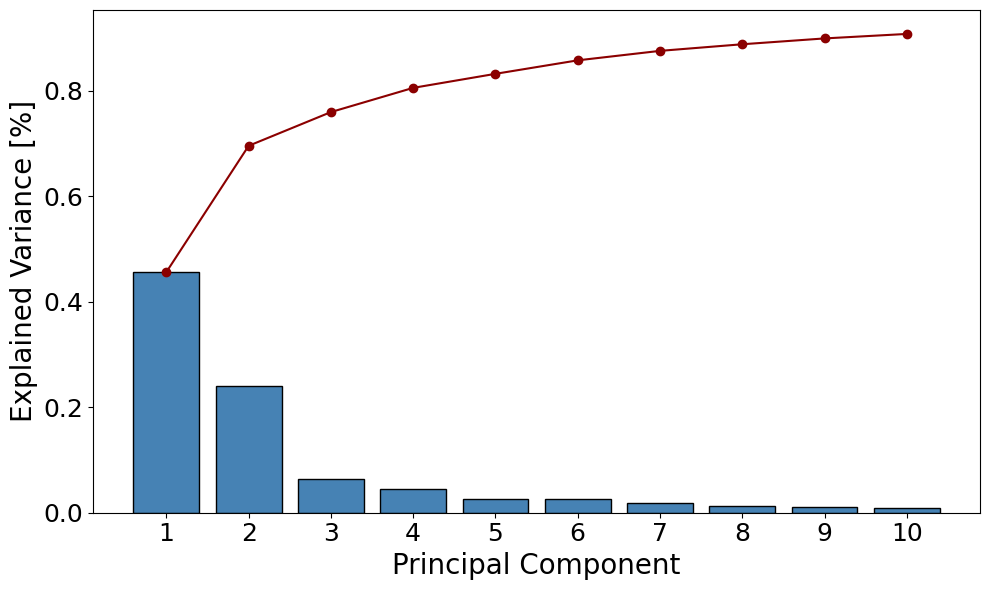

In [270]:
from sklearn.decomposition import PCA

# X_emb: your embeddings matrix, shape (N, d)
pca = PCA(n_components=10, random_state=0)
pca.fit(X_emb)

# Explained variance (absolute) and ratio
explained_var = pca.explained_variance_
explained_ratio = pca.explained_variance_ratio_

print("Explained variance:", explained_var)
print("Explained variance ratio:", explained_ratio)

# Plot variance ratio for SI figure
plt.figure(figsize=(10,6))
plt.bar(range(1, 11), explained_ratio, color="steelblue",edgecolor="black")
plt.plot(range(1, 11), np.cumsum(explained_ratio), marker="o", color="darkred")
plt.xlabel("Principal Component", fontsize=20)
plt.ylabel("Explained Variance [%]", fontsize=20)
plt.xticks(range(1, 11))
#plt.legend()
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.show()

In [ ]:

# Center and reduce embeddings to 1D with PCA
pca = PCA(n_components=1, random_state=0)
coords_1d_pca = pca.fit_transform(X_emb).ravel()  # shape (N,)
# Normalize to [0,1] for color mapping
normed = (coords_1d_pca - coords_1d_pca.min()) / (np.ptp(coords_1d_pca) + 1e-9)
cmap = plt.cm.bone_r  # any single-hue colormap
colors = cmap(normed)

In [ ]:
from sklearn.metrics.pairwise import cosine_distances
D_emb = cosine_distances(X_emb)

from sklearn.manifold import MDS
mds = MDS(n_components=1, dissimilarity="precomputed", random_state=42)
X_mds = mds.fit_transform(D_emb)

coords_1d = mds.fit_transform(D_emb).ravel()



/Users/dahala/anaconda3/envs/vae_env2/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/dahala/anaconda3/envs/vae_env2/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/Users/dahala/anaconda3/envs/vae_env2/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [289]:
from sklearn.manifold import MDS
mds = MDS(n_components=1, random_state=42)
X_norm_mds = mds.fit_transform(X_norm)

coords_1d_norm_mds = mds.fit_transform(X_norm_mds).ravel()

/Users/dahala/anaconda3/envs/vae_env2/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/Users/dahala/anaconda3/envs/vae_env2/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/dahala/anaconda3/envs/vae_env2/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [296]:
import matplotlib as mpl

normed = (coords_1d - coords_1d.min()) / (np.ptp(coords_1d) + 1e-9)
cmap = plt.cm.cividis  # any single-hue colormap
colors = cmap(normed)

In [294]:
import matplotlib as mpl

normed = (coords_1d_norm_mds - coords_1d_norm_mds.min()) / (np.ptp(coords_1d_norm_mds) + 1e-9)
cmap = plt.cm.cividis  # any single-hue colormap
colors = cmap(normed)

In [223]:
domain_color = {'Archaea':"#00EAFF",'Bacteria':"#FEBE10",'Eukaryota':'#FF0000'}
domain_color2 = {'Archaea':'#aec7e8','Bacteria':'#ffbb78','Eukaryota':'#98df8a'}

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

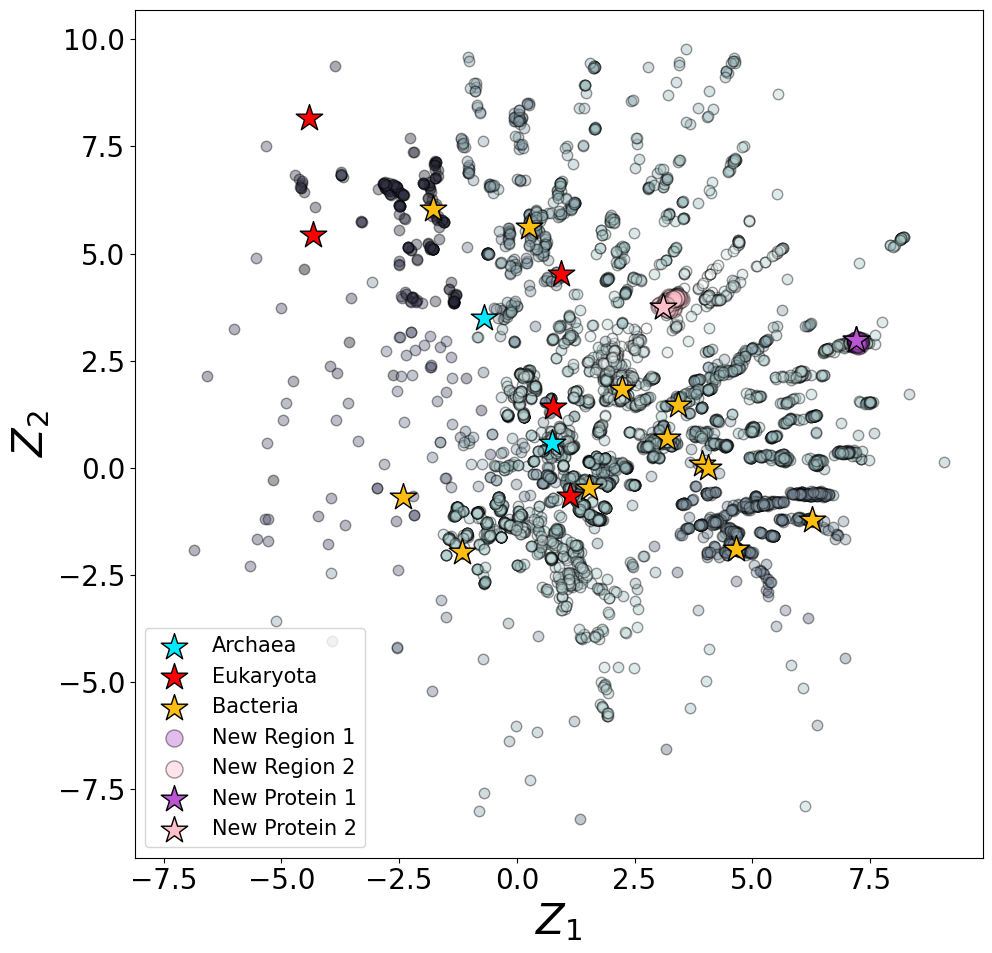

In [233]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


#query_coords = latent_space.key_to_embedding(run.fixed_sequences)
arch_coords = latent_space.key_to_embedding(arch_POI)
euka_coords = latent_space.key_to_embedding(euka_POI)
bact_coords = latent_space.key_to_embedding(bact_POI)
new1_coords = latent_space.key_to_embedding(['WP_139427101.1'])
new2_coords = latent_space.key_to_embedding(['TMB50071.1'])

panel_coords = latent_space.key_to_embedding(panel['ID_VAE'].to_list())

fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))
#'#FEBE10'
for i in range(len(msa_embeddings)):
    ax.plot(msa_embeddings[i, 0], msa_embeddings[i, 1], '.', alpha=0.4, markersize=15, color=colors[i],zorder=0,markeredgecolor='black')

for i in panel['Domain'].unique():
    subset = panel[panel['Domain'] == i]
    ax.scatter(panel_coords[0::2][subset.index], panel_coords[1::2][subset.index], color=domain_color[i],edgecolor='black',s=400,alpha=1,zorder=1,label=i,marker='*')
# ax.scatter(arch_coords[0::2], arch_coords[1::2], color="#0099FF",edgecolor='black',s=300,alpha=1,label='Archaea',zorder=1,marker='*')
# ax.scatter(euka_coords[0::2], euka_coords[1::2], color='red',edgecolor='black',s=300,alpha=1,label='Eukaryota',zorder=1,marker='*')
# ax.scatter(bact_coords[0::2], bact_coords[1::2], color="#FEBE10",edgecolor='black',s=300,alpha=1,label='Bacteria',zorder=1,marker='*')
#64D72F
#7EF148
mask_x = (msa_embeddings[:, 0]<7.3) & (msa_embeddings[:, 0]>7.2)
mask_y = (msa_embeddings[:, 1]<3) & (msa_embeddings[:, 1]>2.5)

mask = mask_x & mask_y
msa_embeddings_new_reg_1 = msa_embeddings[mask]

ax.scatter(msa_embeddings_new_reg_1[:, 0], msa_embeddings_new_reg_1[:, 1], color='#BA55D3',edgecolor='black',s=150,alpha=0.4,zorder=1,label='New Region 1')


mask_x = (msa_embeddings[:, 0]<3.5) & (msa_embeddings[:, 0]>3)
mask_y = (msa_embeddings[:, 1]<4) & (msa_embeddings[:, 1]>3.6)

mask = mask_x & mask_y
msa_embeddings_new_reg_2 = msa_embeddings[mask]

ax.scatter(msa_embeddings_new_reg_2[:, 0], msa_embeddings_new_reg_2[:, 1], color='pink',edgecolor='black',s=150,alpha=0.4,zorder=1,label='New Region 2')

ax.scatter(new1_coords[0::2], new1_coords[1::2], color='#BA55D3',edgecolor='black',s=400,alpha=1,label='New Protein 1',zorder=2,marker='*')
ax.scatter(new2_coords[0::2], new2_coords[1::2], color='pink',edgecolor='black',s=400,alpha=1,label='New Protein 2',zorder=2,marker='*')

# Project 
ax.legend(loc='lower left', fontsize=15)
ax.tick_params(labelsize=20)
ax.set_xlabel(r'$Z_1$', fontsize=30)
ax.set_ylabel(r'$Z_2$', fontsize=30)
ax.set_box_aspect(1)
#ax.set_title('Domains of TRPase proteins',fontsize=30)

plt.tight_layout()
#fig_lat.savefig(os.path.join(run.results, f"latent_space.png"))
    #ax.set_title(f"Latent space projection final")

In [ ]:
with open(run.result+ "/new_region_1_fasta", "w") as output_handle:
    for inbtw in msa_embeddings_new_reg_1:
        for i, emb in enumerate(msa_embeddings):
            if torch.equal(torch.tensor(emb), torch.tensor(inbtw)):
                SeqIO.write(aln[msa_keys[i]], output_handle, "fasta")

In [ ]:
with open(run.result+ "/new_region_2_fasta", "w") as output_handle:
    for inbtw in msa_embeddings_new_reg_2:
        for i, emb in enumerate(msa_embeddings):
            if torch.equal(torch.tensor(emb), torch.tensor(inbtw)):
                SeqIO.write(aln[msa_keys[i]], output_handle, "fasta")

## VAE Training Benchmarking

In [251]:
benchmark_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/EnzymeMiner_TRPase_trim_400_600/benchmark/marginals_benchmark.csv'
benchmark_pd = pd.read_csv(benchmark_path,index_col=0)
benchmark_pd.min().min()

np.float64(0.4547780219780232)

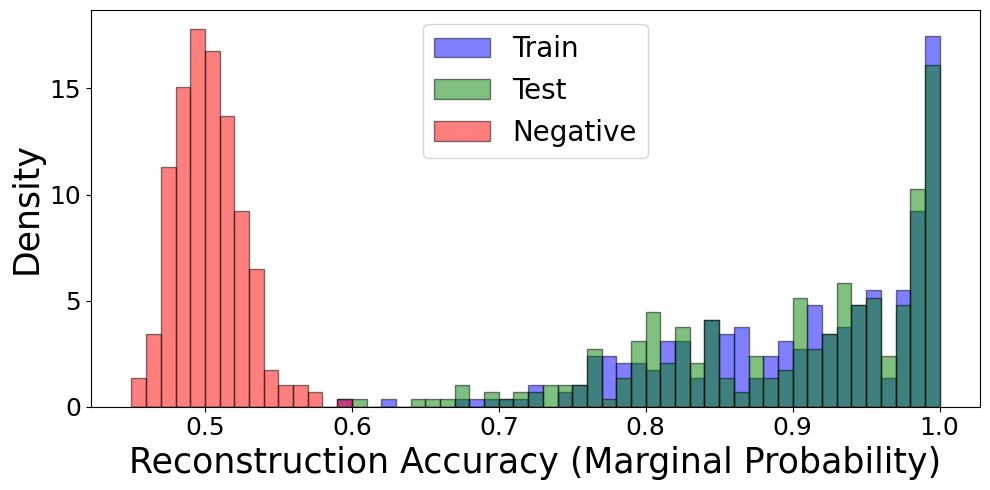

In [254]:
#Plotting the benchmark results

fig_bench, ax = plt.subplots(1, 1,figsize=(10,5))
ax.hist(benchmark_pd['Train'],bins=55,range=(0.45,1),alpha=0.5,color='blue',edgecolor='black',label='Train',density=True)
ax.hist(benchmark_pd['Positive'],bins=55,range=(0.45,1),alpha=0.5,color='green',edgecolor='black',label='Test',density=True)
ax.hist(benchmark_pd['Negative'],bins=55,range=(0.45,1),alpha=0.5,color='red',edgecolor='black',label='Negative',density=True)

ax.set_xlabel('Reconstruction Accuracy (Marginal Probability)', fontsize=25)
ax.set_ylabel('Density', fontsize=25)
ax.legend(loc='upper center', fontsize=20)
ax.tick_params(labelsize=18)
#ax.set_title('Benchmark results',fontsize=30)
plt.tight_layout()
fig_bench.savefig(os.path.join(run.results, f"benchmark.png"))

plt.show()


In [256]:
benchmark_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/EnzymeMiner_TRPase_trim_400_600/logs/train_log.txt'
benchmark_pd = pd.read_csv(benchmark_path,skiprows=3,skipfooter=8,header=None,engine='python',sep='\s+')[[3,5]]
benchmark_pd[3] = benchmark_pd[3].str.replace(',','').astype(float)

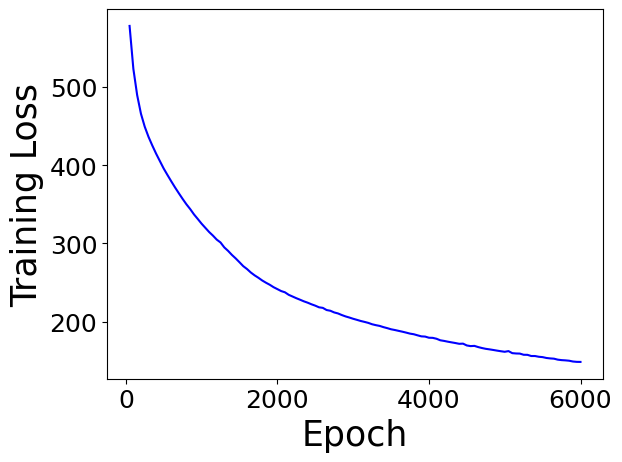

In [259]:
plt.plot(benchmark_pd[3],benchmark_pd[5],color='blue')
plt.xlabel('Epoch',fontsize=25)
plt.ylabel('Training Loss',fontsize=25)
#plt.legend(loc='upper right', fontsize=20)
plt.tick_params(labelsize=18)


## Experimental Data

In [240]:
exp_data = pd.read_csv('../../random_data/TRPase/Table 1.csv',index_col=0)

/var/folders/4n/74gpb5hj01g0m2nkznhtyjrr0000gp/T/ipykernel_3086/139775817.py:11: UserWarning: Adding colorbar to a different Figure <Figure size 600x600 with 2 Axes> than <Figure size 1000x1000 with 1 Axes> which fig.colorbar is called on.
  cb = fig_lat.colorbar(scatter,ax=ax,fraction=0.04569, pad=0.04)


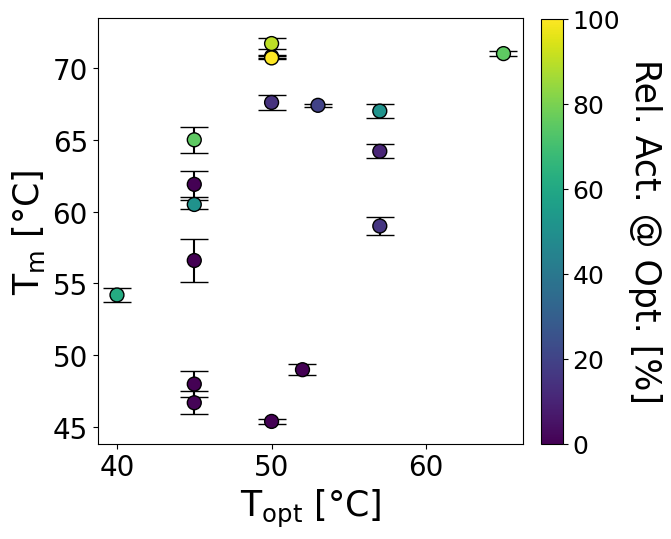

In [235]:
fig, ax = plt.subplots(1, 1,figsize=(6,6))

scatter =plt.scatter(exp_data['T'], exp_data['Tm'], edgecolor='black', alpha=1,c=exp_data['rel_act_opt'],zorder=1,s=100)
plt.errorbar(exp_data['T'], exp_data['Tm'], yerr=exp_data['Tm_std'], fmt='o', alpha=1, zorder=0,capsize=10,markersize=1,ecolor='k')
plt.ylabel('T$_\mathrm{m}$ [°C]',fontsize=25)
plt.xlabel('T$_\mathrm{opt}$ [°C]',fontsize=25)

ax.set_box_aspect(1)
ax.tick_params(labelsize=20)

cb = fig_lat.colorbar(scatter,ax=ax,fraction=0.04569, pad=0.04)
cb.set_label(r'Rel. Act. @ Opt. [%]',fontsize=25,rotation=270,labelpad=30)
cb.ax.tick_params(labelsize=18)


/var/folders/4n/74gpb5hj01g0m2nkznhtyjrr0000gp/T/ipykernel_3086/415775812.py:11: UserWarning: Adding colorbar to a different Figure <Figure size 600x600 with 2 Axes> than <Figure size 1000x1000 with 1 Axes> which fig.colorbar is called on.
  cb = fig_lat.colorbar(scatter,ax=ax,fraction=0.04569, pad=0.04)


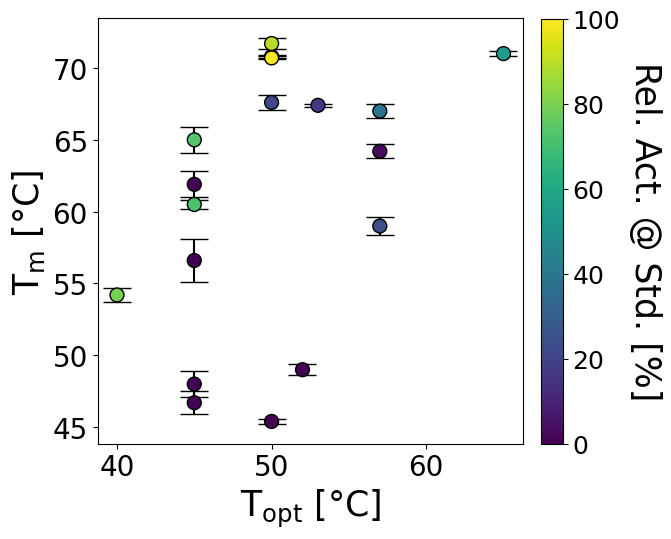

In [236]:
fig, ax = plt.subplots(1, 1,figsize=(6,6))

scatter =plt.scatter(exp_data['T'], exp_data['Tm'], edgecolor='black', alpha=1,c=exp_data['rel_act_std'],zorder=1,s=100)
plt.errorbar(exp_data['T'], exp_data['Tm'], yerr=exp_data['Tm_std'], fmt='o', alpha=1, zorder=0,capsize=10,markersize=1,ecolor='k')
plt.ylabel('T$_\mathrm{m}$ [°C]',fontsize=25)
plt.xlabel('T$_\mathrm{opt}$ [°C]',fontsize=25)

ax.set_box_aspect(1)
ax.tick_params(labelsize=20)

cb = fig_lat.colorbar(scatter,ax=ax,fraction=0.04569, pad=0.04)
cb.set_label(r'Rel. Act. @ Std. [%]',fontsize=25,rotation=270,labelpad=30)
cb.ax.tick_params(labelsize=18)


In [247]:
kin_data = pd.read_csv('../../random_data/TRPase/kin_data_commasep.csv',index_col=0)
kin_data['Conditions'] = ['Standard','Assay','Optimal']*6
cond_shape_dict = {'Standard':'o','Assay':'s','Optimal':'*'}
size_dict = {'Standard':200,'Assay':200,'Optimal':400}
kin_prot_color_dict = {'TtiTIL':'#1f77b4',
                       'AsoTIL':'#ff7f0e',
                       'PvuTIL':'#2ca02c',
                       'PreTIL':'#d62728',
                       'EcoTIL':'#9467bd',
                       'VchTIL':'#8c564b',

}
import matplotlib.colors as mcolors
# Normalize to the temperature range
norm = mcolors.Normalize(vmin=exp_data['T'][kin_data.index.unique()].min(), vmax=exp_data['T'][kin_data.index.unique()].max())
cmap = plt.colormaps.get_cmap("coolwarm")  # blue → red
# Create dictionary of colors
kin_prot_color_dict = {prot: cmap(norm(temp)) for prot, temp in exp_data['T'][kin_data.index.unique()].items()}

# Topt values for the 6 enzymes
prot_Topt = {
    'TtiTIL': 45,
    'AsoTIL': 65,
    'PvuTIL': 50,
    'PreTIL': 50,
    'EcoTIL': 45,
    'VchTIL': 40
}

# sort proteins by Topt
sorted_prots = sorted(prot_Topt.items(), key=lambda x: x[1])

# get 6 discrete colors from blue→red
cmap = cm.get_cmap("coolwarm", 6)  # 6 evenly spaced colors
colors = [cmap(i) for i in range(6)]
# map proteins to colors in Topt order
kin_prot_color_dict = {
    prot: colors[i] for i, (prot, _) in enumerate(sorted_prots)
}

/var/folders/4n/74gpb5hj01g0m2nkznhtyjrr0000gp/T/ipykernel_3086/390289542.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm", 6)  # 6 evenly spaced colors


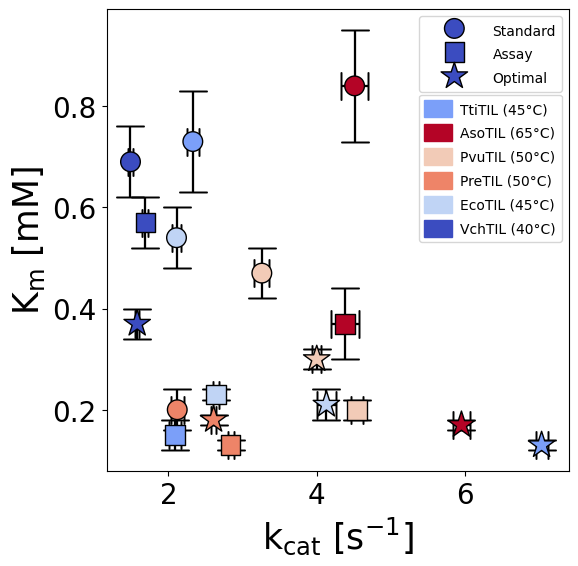

In [249]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(1, 1,figsize=(6,6))

for cond in kin_data['Conditions'].unique():
    subset = kin_data[kin_data['Conditions']==cond]
    plt.scatter(subset['kcat'], subset['KM'], edgecolor='black', alpha=1,label=cond,zorder=1,s=size_dict[cond],marker=cond_shape_dict[cond],
            color=list(kin_prot_color_dict.values()))

    plt.errorbar(kin_data['kcat'], kin_data['KM'],xerr=kin_data['kcat_std'], yerr=kin_data['KM_std'],
                fmt='o', alpha=1, zorder=0,capsize=10,markersize=0,ecolor='k',
                markeredgecolor='black',color='black')
plt.ylabel('K$_\mathrm{m}$ [mM]',fontsize=25)
plt.xlabel('k$_\mathrm{cat}$ [s$^{-1}$]',fontsize=25)


# --- First legend (marker shapes) ---
shape_legend = ax.legend(
    title=None,
    loc="upper right",
    bbox_to_anchor=(1, 1),
    fontsize=10,
    handlelength=4.3,
    handleheight=1.5,
    handletextpad=0.6
)
ax.add_artist(shape_legend)

# --- Second legend (protein colors) ---
prot_patches = [
    mpatches.Patch(color=kin_prot_color_dict[prot], label=f"{prot} ({temp}°C)")
    for prot, temp in exp_data['T'][kin_data.index.unique()].items()
]

color_legend = ax.legend(
    handles=prot_patches,
    loc="upper right",
    bbox_to_anchor=(1, 0.83),  # adjust vertical stacking
    fontsize=10,
    handlelength=2,
    handleheight=1.5,
    handletextpad=0.6
)



ax.set_box_aspect(1)
ax.tick_params(labelsize=20)

plt.show()

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

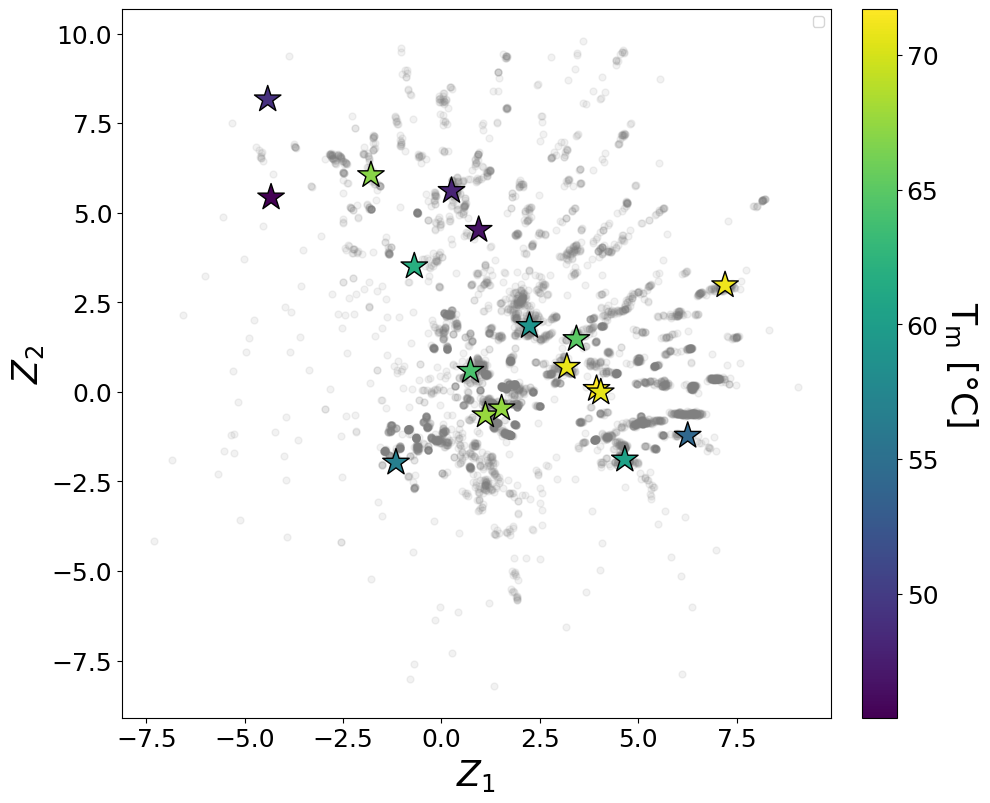

In [246]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]

POI_coords = latent_space.key_to_embedding(name_converter.loc[exp_data.index].to_numpy())

fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=10, color='grey',zorder=0)


scatter = ax.scatter(POI_coords[0::2], POI_coords[1::2],edgecolor='black',s=400,c=np.array(exp_data.Tm.to_numpy(),dtype=float),zorder=1,marker='*',cmap='viridis')
cb = fig_lat.colorbar(scatter,ax=ax,fraction=0.04569, pad=0.04)
cb.set_label(r'T$_\mathrm{m}$ [°C]',fontsize=25,rotation=270,labelpad=30)
cb.ax.tick_params(labelsize=18)

# Project 
ax.legend()
#ax.legend(loc='lower left', fontsize=20)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)
#ax.set_title('Tm values of TRPase proteins',fontsize=30)

#fig_lat.savefig(os.path.join(run.results, f"latent_space_Tm.png"))
    #ax.set_title(f"Latent space projection final")

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


/var/folders/4n/74gpb5hj01g0m2nkznhtyjrr0000gp/T/ipykernel_3086/179851567.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


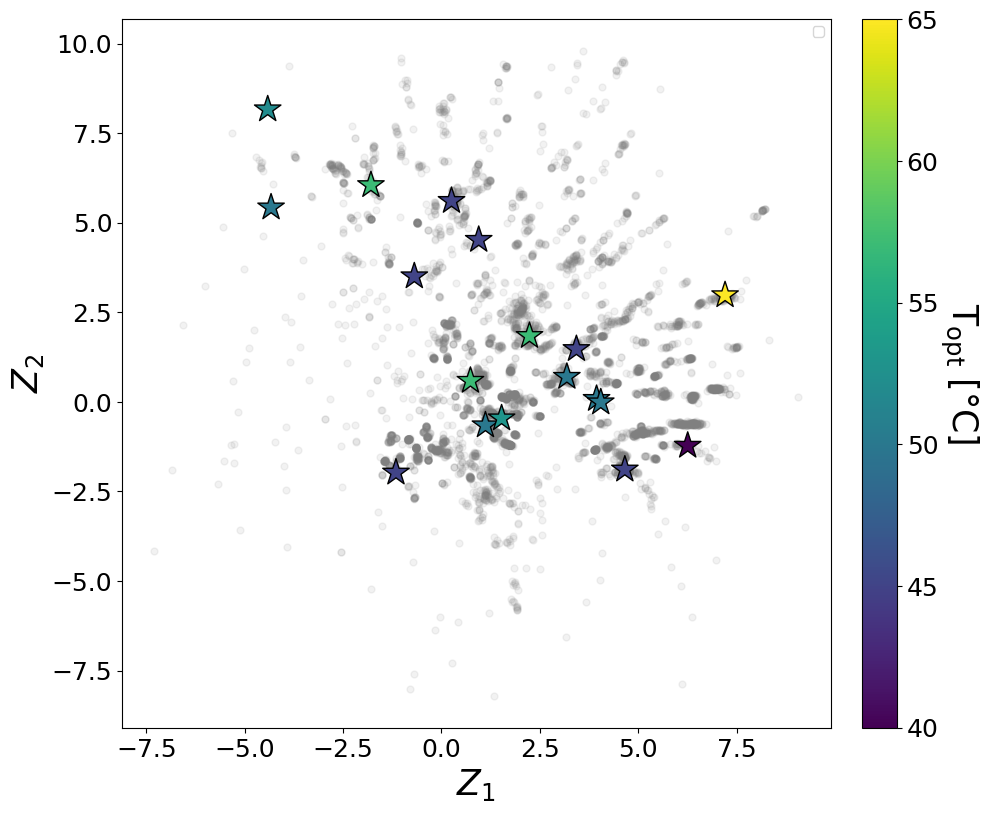

In [67]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]

POI_coords = latent_space.key_to_embedding(name_converter.loc[exp_data.index].to_numpy())

fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=10, color='grey',zorder=0)


scatter = ax.scatter(POI_coords[0::2], POI_coords[1::2],edgecolor='black',s=400,c=np.array(exp_data['T'].to_numpy(),dtype=float),zorder=1,marker='*')
cb = fig_lat.colorbar(scatter,ax=ax,fraction=0.04569, pad=0.04)
cb.set_label(r'T$_\mathrm{opt}$ [°C]',fontsize=25,rotation=270,labelpad=30)
cb.ax.tick_params(labelsize=18)

# Project 
ax.legend()
#ax.legend(loc='lower left', fontsize=20)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)
#ax.set_title('Tm values of TRPase proteins',fontsize=30)

#fig_lat.savefig(os.path.join(run.results, f"latent_space_Tm.png"))
    #ax.set_title(f"Latent space projection final"

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

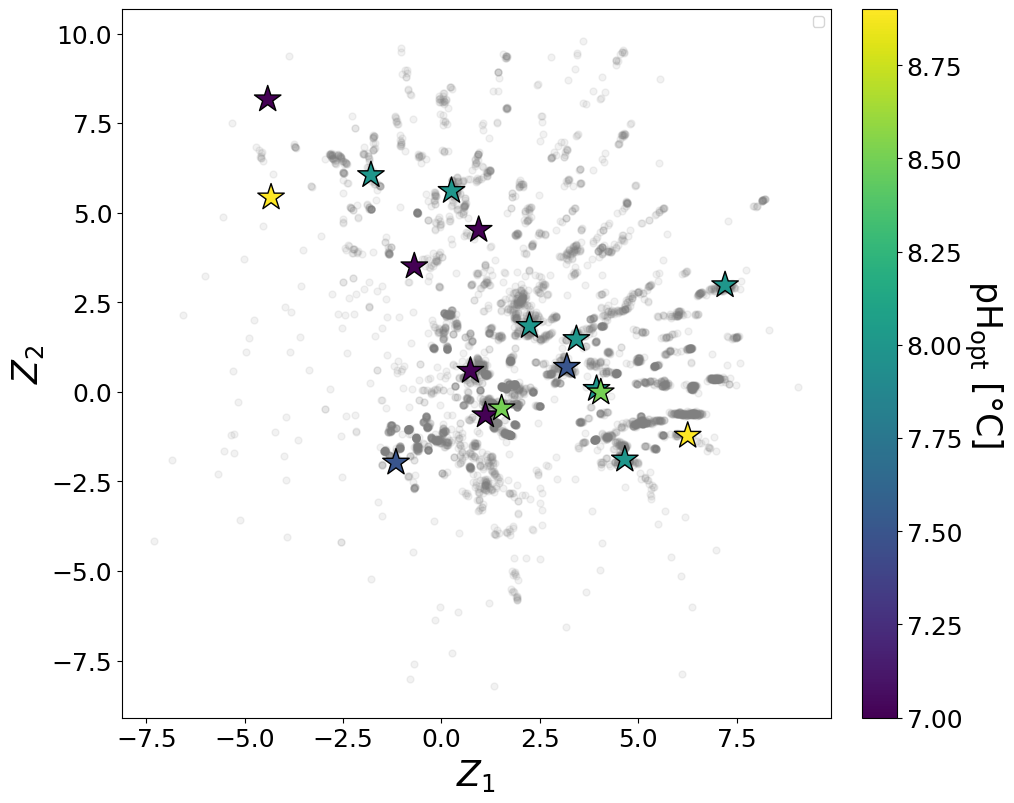

In [68]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]

POI_coords = latent_space.key_to_embedding(name_converter.loc[exp_data.index].to_numpy())

fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=10, color='grey',zorder=0)


scatter = ax.scatter(POI_coords[0::2], POI_coords[1::2],edgecolor='black',s=400,c=np.array(exp_data['pH'].to_numpy(),dtype=float),zorder=1,marker='*')
cb = fig_lat.colorbar(scatter,ax=ax,fraction=0.04569, pad=0.04)
cb.set_label('pH$_\mathrm{opt}$ [°C]',fontsize=25,rotation=270,labelpad=30)
cb.ax.tick_params(labelsize=18)

# Project 
ax.legend()
#ax.legend(loc='lower left', fontsize=20)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)
#ax.set_title('Tm values of TRPase proteins',fontsize=30)

#fig_lat.savefig(os.path.join(run.results, f"latent_space_Tm.png"))
    #ax.set_title(f"Latent space projection final"

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

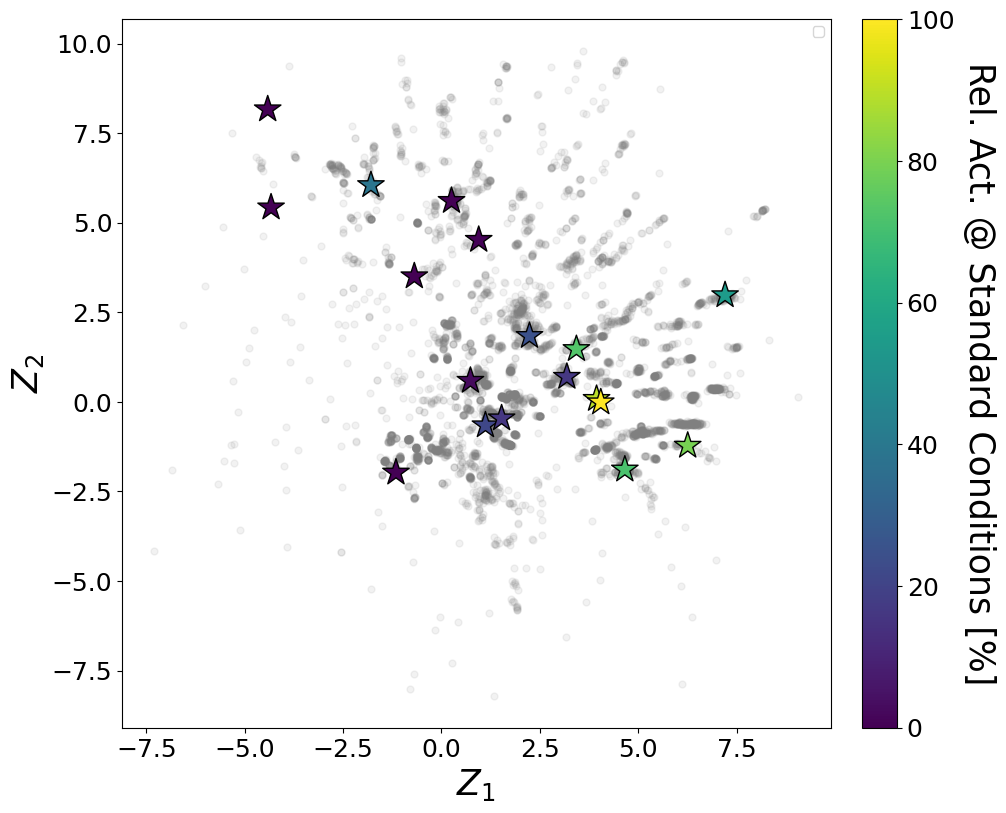

In [69]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]

POI_coords = latent_space.key_to_embedding(name_converter.loc[exp_data.index].to_numpy())

fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=10, color='grey',zorder=0)


scatter = ax.scatter(POI_coords[0::2], POI_coords[1::2],edgecolor='black',s=400,c=np.array(exp_data['rel_act_std'].to_numpy(),dtype=float),zorder=1,marker='*')
cb = fig_lat.colorbar(scatter,ax=ax,fraction=0.04569, pad=0.04)
cb.set_label(r'Rel. Act. @ Standard Conditions [%]',fontsize=25,rotation=270,labelpad=30)
cb.ax.tick_params(labelsize=18)

# Project 
ax.legend()
#ax.legend(loc='lower left', fontsize=20)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)
#ax.set_title('Tm values of TRPase proteins',fontsize=30)

#fig_lat.savefig(os.path.join(run.results, f"latent_space_Tm.png"))
    #ax.set_title(f"Latent space projection final"

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


/var/folders/4n/74gpb5hj01g0m2nkznhtyjrr0000gp/T/ipykernel_3086/3022808675.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


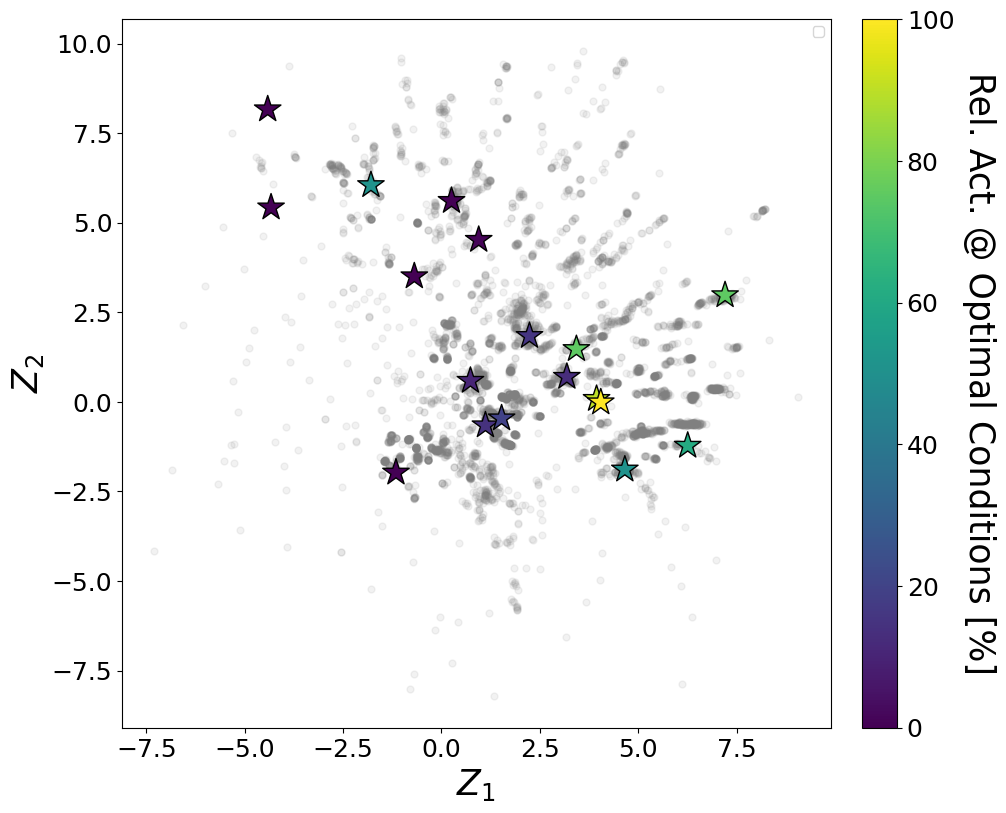

In [70]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]

POI_coords = latent_space.key_to_embedding(name_converter.loc[exp_data.index].to_numpy())

fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=10, color='grey',zorder=0)


scatter = ax.scatter(POI_coords[0::2], POI_coords[1::2],edgecolor='black',s=400,c=np.array(exp_data['rel_act_opt'].to_numpy(),dtype=float),zorder=1,marker='*')
cb = fig_lat.colorbar(scatter,ax=ax,fraction=0.04569, pad=0.04)
cb.set_label(r'Rel. Act. @ Optimal Conditions [%]',fontsize=25,rotation=270,labelpad=30)
cb.ax.tick_params(labelsize=18)

# Project 
ax.legend()
#ax.legend(loc='lower left', fontsize=20)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)
#ax.set_title('Tm values of TRPase proteins',fontsize=30)

#fig_lat.savefig(os.path.join(run.results, f"latent_space_Tm.png"))
    #ax.set_title(f"Latent space projection final"

## Morphing

In [ ]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


POI_coords = latent_space.key_to_embedding(POI)

fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=10, color='grey',zorder=0)

ax.scatter(POI_coords[0::2][0], POI_coords[1::2][0], color='#B23A48',edgecolor='black',s=200,alpha=1,zorder=1,label='BlaTIL (slow, stable)')
ax.scatter(POI_coords[0::2][1], POI_coords[1::2][1], color='#4B8F8C',edgecolor='black',s=200,alpha=1,zorder=1,label='PhaTIL (fast, unstable)')

mask_x = (msa_embeddings[:, 0]<3.7) & (msa_embeddings[:, 0]>3.403)
mask_y = (msa_embeddings[:, 1]<0.6) & (msa_embeddings[:, 1]>0)

mask = mask_x & mask_y
msa_embeddings_sel_inbetween = msa_embeddings[mask]

ax.scatter(msa_embeddings_sel_inbetween[:, 0], msa_embeddings_sel_inbetween[:, 1], color='blue',edgecolor='black',s=100,alpha=0.8,zorder=1,label='In between')


ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)
ax.set_title('Zoomed in on POI',fontsize=30)

ax.set_xlim(2.5, 4.5)
ax.set_ylim(-1, 1.5)
ax.legend(loc='lower left', fontsize=25)

fig_lat.savefig(os.path.join(run.results, f"latent_space_POIzoom.png"))
    #ax.set_title(f"Latent space projection final")

In [ ]:
with open(run.result+ "/inbetween_select.fasta", "w") as output_handle:
    for inbtw in msa_embeddings_sel_inbetween:
        for i, emb in enumerate(msa_embeddings):
            if torch.equal(torch.tensor(emb), torch.tensor(inbtw)):
                print(msa_keys[i])
                print(msa[msa_keys[i]])
                print(aln[msa_keys[i]].seq)
                print()
                SeqIO.write(aln[msa_keys[i]], output_handle, "fasta")

In [ ]:
def decoding(mus, sigmas, samples=500):
    with torch.no_grad():
        mus = torch.tensor(mus.reshape(-1,2)).to(torch.float32)
        sigmas = torch.tensor(sigmas.reshape(-1,2)).to(torch.float32)
        torch.manual_seed(42)
        numerical_sequences = vae.decode_samples(mus, sigmas, samples)
    return numerical_sequences

In [ ]:
vae = latent_space.vae

In [ ]:
sequences_test = decoding(POI_coords,np.ones_like(POI_coords),samples=500)

In [ ]:
def number_to_amino(sequence_list) -> dict:
    """ Transform from number encoding into amino acid alphabet """
    reverse_index = {0: '-'}
    i = 1
    for a in MSA.aa:
        reverse_index[i] = a
        i += 1
    transformed = {}
    # Sequences back to amino acid representation
    for i,seq in enumerate(sequence_list):
        to_amino = seq.tolist()
        amino_seq = [reverse_index[s] for s in to_amino]
        transformed[i] = amino_seq
    return transformed

In [ ]:
stacked_seq = None
for i in range(500):
    seq_ = sequences_test[i]
    if stacked_seq is None:
        stacked_seq = seq_
    else:
        stacked_seq = np.vstack((stacked_seq,seq_))

In [ ]:
consensus = mode(stacked_seq, axis=0, keepdims=False).mode

In [ ]:
consensus_seq = number_to_amino(sequences_test)[0]

In [ ]:
POI_seq = ['MKYPAEPFKIKMIEPLRLISREERITALKEAGYNPFSLRAEDVYIDLLTDSGTGAMSDRQWAGLMQGDESYAGSRSFYHLQDSVRDVIGYSYVVPTHQGRGAEQVLFPLLIKPGQSVISNWHFDTTRVHVELAGGKAIDLVTDEALDTNTYHAFKGNIDIEKARKVIEETGKENIALLIITITNNSAGGQPVSMENIKQASALAKEYGLRFLLDAARFSENAYFIKQREAGYQQKSIRQIVREMFTYADAFTMSAKKDGLVNIGGLIGIREKQELYEQIRSAVVPLEGFPTYGGLAGRDMEALAAGLQEVVEEEYLHYRIAQIAYLGDRLVAGGIPIQTPTGGHAVFVDAKKMLSHIPFDQFPGQVLANELYVESGVRAVEVGSLLLGRDPKTNQQLVSPLELLRLTIPRRVYTYAHMDVIADGLIRIKERAHELRGLTFTYEPPMLRHFTARLKPVEEK',
            'MAKRIVEPFRIKMVEKIRVPSREEREAALKEAGYNPFLLPSSAVYIDLLTDSGTNAMSDHQWAAMITGDEAYAGSRNYYDLKDKAKELFNYDYIIPAHQGRGAENILFPVLLKYKQKEGKAKNPVFISNFHFDTTAAHVELNGCKAINIVTEKAFDSETYDDWKGDFDIKKLKENIAQHGADNIVAIVSTVTCNSAGGQPVSMSNLKEVYEIAKQHGIFVVMDSARFCENAYFIKERDPKYKNATIKEVIFDMYKYADALTMSAKKDPLLNIGGLVAIRDNEEIFTLARQRCVPMEGFVTYGGLAGRDMAAMVQGLEEGTEEEYLHYRIGQVKYLGDRLREAGIPIQYPTGGHAVFVDCKKLVPQIPGDQFPAQAVINALYLESGVRAVEIGSFLLGRDPATGEQKHADMEFMRLTIARRVYTNDHMDYIADALIGLKEKFATLKGLEFEYEPPVLRHFTARLKPIE'
            ]

In [ ]:
def find_missing_positions(true_seq, msa_seq):
    missing_positions = []
    true_index = 0
    msa_index = 0
    
    while true_index < len(true_seq) and msa_index < len(msa_seq):
        if msa_seq[msa_index] == '-':
            # Skip gap in the MSA
            msa_index += 1
        elif true_seq[true_index] != msa_seq[msa_index]:
            # Mismatch or missing residue
            missing_positions.append((true_index, true_seq[true_index]))
            true_index += 1
        else:
            # Match
            true_index += 1
            msa_index += 1
    
    # If there’s anything left in the true sequence after the MSA ends
    if true_index < len(true_seq):
        for i in range(true_index, len(true_seq)):
            missing_positions.append((i, true_seq[i]))
    
    return missing_positions

def insert_missing_amino_acids(msa_seq, missing_positions):
    # Convert to list for easy insertion
    msa_list = list(msa_seq)
    
    for pos, residue in sorted(missing_positions):
        if pos <= len(msa_list):
            msa_list.insert(pos, residue)
        else:
            # If the position is out of bounds, append to the end
            msa_list.append(residue)
    
    # Convert back to string
    return ''.join(msa_list)



In [ ]:
missing_positions = find_missing_positions(POI_seq[1], POI_seq[0])
print("Missing positions:", missing_positions)

In [ ]:
msa = MSA.load_msa(run.dataset)
decoded_seqs = []
for i in range(2):
    print('Using template sequence:', POI[i])
    msa_seq_ = ''.join([msa[POI[i]][s] for s in msa_columns])
    missing_positions = find_missing_positions(POI_seq[i], msa_seq_)
    print("Missing positions:", missing_positions)
    decoded_template = insert_missing_amino_acids(consensus_seq, missing_positions)
    decoded_seqs.append(decoded_template)
    print(decoded_template)
    print()

In [ ]:
msa_seqs = []
for i in range(2):
    msa_seq_ = ''.join([msa[POI[i]][s] for s in msa_columns])
    msa_seqs.append(msa_seq_)

In [ ]:
import random

def identify_mutations(seq1, seq2):
    mutations = []
    for i, (res1, res2) in enumerate(zip(seq1, seq2)):
        if res1 != res2:
            mutations.append((i, res1, res2))  # (position, original, target)
    return mutations

def apply_mutation(seq, mutation):
    index, _, new_res = mutation
    seq = list(seq)
    seq[index] = new_res
    return ''.join(seq)

def random_walk_mutation(start_seq, target_seq, max_steps=1000, num_walks=1, seed=42):
    # Set the random seed for reproducibility
    random.seed(seed)
    
    all_walks = []  # To store results from all walks
    all_sequences = []  # To store all generated sequences across walks

    for walk in range(num_walks):
        mutations = identify_mutations(start_seq, target_seq)
        current_seq = start_seq
        mutation_path = []
        walk_sequences = [start_seq]
        
        for step in range(max_steps):
            if current_seq == target_seq:
                break
            
            # Pick a random mutation from the remaining pool
            mutation = random.choice(mutations)
            current_seq = apply_mutation(current_seq, mutation)
            mutation_path.append(mutation)
            walk_sequences.append(current_seq)
            
            # Remove applied mutation from the pool
            mutations.remove(mutation)
        
        # Save the results of this walk
        all_walks.append({
            "final_sequence": current_seq,
            "mutation_path": mutation_path,
            "sequences": walk_sequences
        })
        all_sequences.extend(walk_sequences)
    print(all_sequences)
    # Encode all sequences in one batch
    mu,_ = latent_space.encode(all_sequences)
    
    # Assign latent coordinates back to the walk data
    idx = 0
    for walk in all_walks:
        walk['latent_coords'] = mu[idx: idx + len(walk['sequences'])]
        idx += len(walk['sequences'])
    
    return all_walks, mu

In [ ]:
all_walks, all_latent_coords = random_walk_mutation(msa_seqs[1], msa_seqs[0],num_walks=1000)

In [ ]:
all_sequences = [all_walks[s]['sequences'] for s in range(len(all_walks))]
all_sequences = np.array(all_sequences).reshape(-1)

In [ ]:
# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


POI_coords = latent_space.key_to_embedding(POI)

fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

for walk in all_walks:
    ax.plot(walk['latent_coords'][:, 0], walk['latent_coords'][:, 1], '-', alpha=0.01, color='grey',zorder=0)
    #ax.plot(walk['latent_coords'][:, 0], walk['latent_coords'][:, 1], '-', alpha=0.1, color='grey',zorder=0)

ax.scatter(POI_coords[0::2][0], POI_coords[1::2][0], color='#B23A48',edgecolor='black',s=200,alpha=1,zorder=1,label='End (BlaTIL)')
ax.scatter(POI_coords[0::2][1], POI_coords[1::2][1], color='#4B8F8C',edgecolor='black',s=200,alpha=1,zorder=1,label='Start (PhaTIL)')

# Project 
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)
#x.set_title('1000 Random Walks in Latent Space',fontsize=30)

ax.legend(loc='lower left', fontsize=25)

plt.show()
#ax.set_xlim(2, 5)
#ax.set_ylim(-2, 2)


In [ ]:
# Example latent points (replace with your actual latent coords)
latent_points = np.array([list(z) for z in all_latent_coords])

# Fit KernelDensity
kde = KernelDensity(bandwidth=0.02, kernel='gaussian')  # bandwidth controls smoothness
kde.fit(latent_points)

In [ ]:
# Create a grid over the plot area
x = np.linspace(3.0, 4.0, 200)
y = np.linspace(0.0, 0.8, 200)
X, Y = np.meshgrid(x, y)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T

# Evaluate KDE over the grid
Z = kde.score_samples(grid_points)
Z = np.exp(Z).reshape(X.shape)  # Convert log density to actual density


In [ ]:
# Invert density to use as a cost map (high density = low cost)
cost_map = 1 / (Z + 1e-10)

# Find shortest path using A* through the highest density
start = np.unravel_index(np.argmin(np.sum((grid_points - latent_points[0])**2, axis=1)), X.shape)
end = np.unravel_index(np.argmin(np.sum((grid_points - latent_points[-1])**2, axis=1)), X.shape)
path, _ = route_through_array(cost_map, start, end, fully_connected=True)

# Convert path to coordinates
path_coords = np.array([(X[i, j], Y[i, j]) for i, j in path])

In [ ]:
tree = cKDTree(latent_points)
distances_path, indices_path = tree.query(path_coords)

# Get sequences along the path
path_sequences = [all_sequences[idx] for idx in indices_path]
path_coords_true = np.array([all_latent_coords[idx].tolist() for idx in indices_path])


In [ ]:
Z_start = latent_points[0]
Z_end = latent_points[-1]

# Step 1: Interpolate quartile points between Z_start and Z_end
Z_25 = Z_start + 0.25 * (Z_end - Z_start)
Z_50 = Z_start + 0.50 * (Z_end - Z_start)
Z_75 = Z_start + 0.75 * (Z_end - Z_start)
quartile_points = np.array([Z_25, Z_50, Z_75])

# Store indices of closest black dots
closest_indices_per_quartile = []

for zp in quartile_points:
    distances = np.linalg.norm(path_coords_true - zp, axis=1)
    closest_indices = np.argsort(distances)[:5]
    closest_indices_per_quartile.append(closest_indices)

# Optional: get coordinates and sequences
closest_coords_per_quartile = [path_coords_true[idxs] for idxs in closest_indices_per_quartile]
sequences_per_quartile = [[all_sequences[i] for i in idxs] for idxs in closest_indices_per_quartile]


In [ ]:
# Plot KDE and path
fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

density_map = ax.contourf(X, Y, np.log1p(Z), levels=50, cmap='plasma',zorder=0)
cb = fig_lat.colorbar(density_map,ax=ax,fraction=0.04569, pad=0.04)
cb.set_label('Density (log)',fontsize=25,rotation=270,labelpad=30)
cb.ax.tick_params(labelsize=18)

# Plot the path
ax.plot(path_coords[:, 0], path_coords[:, 1], color='white', linewidth=2, label="Optimal Path", zorder=1)

# Plot the latent points
ax.scatter(path_coords_true[:, 0], path_coords_true[:, 1], s=3, color='black', alpha=1, label="Optimal Latent Points", zorder=2)

ax.scatter(POI_coords[0::2][0], POI_coords[1::2][0], color='#B23A48',edgecolor='black',s=200,alpha=1,zorder=3,label='End (BlaTIL)')
ax.scatter(POI_coords[0::2][1], POI_coords[1::2][1], color='#4B8F8C',edgecolor='black',s=200,alpha=1,zorder=3,label='Start (PhaTIL)')

# Mark quartile points
# Choose a colormap
cmap = cm.get_cmap('Greys')  # or 'viridis', 'coolwarm', 'magma', etc.

# Pick 3 points along the gradient (normalized 0-1 scale)
colors = [cmap(0.25), cmap(0.5), cmap(0.75)]
ax.scatter(Z_25[0], Z_25[1], color=colors[0], s=80, label="25%", edgecolors='black', zorder=3)
ax.scatter(Z_50[0], Z_50[1], color=colors[1], s=80, label="Mid", edgecolors='black', zorder=3)
ax.scatter(Z_75[0], Z_75[1], color=colors[2], s=80, label="75%", edgecolors='black', zorder=3)

# Closest points to quartiles
for i, (coords, seqs) in enumerate(zip(closest_coords_per_quartile, sequences_per_quartile)):
    for j, (coord, seq) in enumerate(zip(coords, seqs)):
        if j == 0 and i == 0:
            ax.scatter(coord[0], coord[1], s=10, color='#A1E44D', edgecolors='black', zorder=4, label=f"Closest to Quartiles", alpha=1)
        else:
            ax.scatter(coord[0], coord[1], s=10, color='#A1E44D', edgecolors='black', zorder=4, alpha=1)

# Label axes
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)
ax.legend()
plt.show()

In [ ]:
# Plot KDE and path
fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

density_map = ax.contourf(X, Y, np.log1p(Z), levels=50, cmap='plasma',zorder=0)
cb = fig_lat.colorbar(density_map,ax=ax,fraction=0.04569, pad=0.04)
cb.set_label('Density (log)',fontsize=25,rotation=270,labelpad=30)
cb.ax.tick_params(labelsize=18)


# Mark start and end points
ax.scatter(POI_coords[0::2][0], POI_coords[1::2][0], color='#B23A48',edgecolor='black',s=200,alpha=1,zorder=3,label='End (BlaTIL)')
ax.scatter(POI_coords[0::2][1], POI_coords[1::2][1], color='#4B8F8C',edgecolor='black',s=200,alpha=1,zorder=3,label='Start (PhaTIL)')

# Label axes
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)
ax.legend()
plt.show()

In [ ]:
decoded_seqs = {}
print('Using template sequence:', POI[1])
msa_seq_ = ''.join([[s] for s in msa_columns])
missing_positions = find_missing_positions(POI_seq[1], msa_seq_)
print("Missing positions:", missing_positions)
for i,quartile in enumerate([25, 50, 75]):
    dec_seq_ = []
    for seq in sequences_per_quartile[i]:
        decoded_template = insert_missing_amino_acids(seq, missing_positions)
        dec_seq_.append(decoded_template)
    decoded_seqs[quartile] = dec_seq_

In [ ]:
decoded_template

In [ ]:
msa_seq_

In [ ]:
sequences_per_quartile[2]

In [ ]:

with open(run.result+'/closest_quartile_sequences.fasta', 'w') as output_file:
    for quartile, seqs in decoded_seqs.items():
        for i,seq in enumerate(seqs):
            output_file.write(f">Quartile_{quartile}_{i}\n")
            output_file.write(f"{seq}\n")

for quartile, seqs in decoded_seqs.items():
    for i,seq in enumerate(seqs):
        with open(run.result+f'/closest_quartile_sequences_{quartile}_{i}.fasta', 'w') as output:
            output.write(f">Quartile_{quartile}_{i}\n")
            output.write(f"{seq}\n")



In [ ]:
# Plot KDE and path
fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

density_map = ax.contourf(X, Y, np.log1p(Z), levels=50, cmap='Greys',zorder=0)
cb = fig_lat.colorbar(density_map,ax=ax,fraction=0.04569, pad=0.04)
cb.set_label('Density (log)',fontsize=25,rotation=270,labelpad=30)
cb.ax.tick_params(labelsize=18)

# Plot the path
ax.plot(path_coords[:, 0], path_coords[:, 1], color='white', linewidth=2, label="Optimal Path", zorder=1)

# Plot the latent points
ax.scatter(path_coords_true[:, 0], path_coords_true[:, 1], s=3, color='black', alpha=1, label="Optimal Latent Points", zorder=2)

# Mark start and end points
ax.scatter(POI_coords[0::2][0], POI_coords[1::2][0], color='#B23A48',edgecolor='black',s=200,alpha=1,zorder=3,label='End (BlaTIL)')
ax.scatter(POI_coords[0::2][1], POI_coords[1::2][1], color='#4B8F8C',edgecolor='black',s=200,alpha=1,zorder=3,label='Start (PhaTIL)')

# Mark quartile points
# Choose a colormap
cmap = cm.get_cmap('Greys')  # or 'viridis', 'coolwarm', 'magma', etc.

# Pick 3 points along the gradient (normalized 0-1 scale)
colors = [cmap(0.25), cmap(0.5), cmap(0.75)]
ax.scatter(Z_25[0], Z_25[1], color=colors[0], s=80, label="25%", edgecolors='black', zorder=3)
ax.scatter(Z_50[0], Z_50[1], color=colors[1], s=80, label="Mid", edgecolors='black', zorder=3)
ax.scatter(Z_75[0], Z_75[1], color=colors[2], s=80, label="75%", edgecolors='black', zorder=3)

# Closest points to quartiles
for i, (coords, seqs) in enumerate(zip(closest_coords_per_quartile, sequences_per_quartile)):
    for j, (coord, seq) in enumerate(zip(coords, seqs)):
        if j == 0 and i == 0:
            ax.scatter(coord[0], coord[1], s=10, color='#A1E44D', edgecolors='black', zorder=4, label=f"Closest to Quartiles", alpha=1)
        else:
            ax.scatter(coord[0], coord[1], s=10, color='#A1E44D', edgecolors='black', zorder=4, alpha=1)

# Label axes
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)
ax.legend()
plt.show()

In [ ]:
# Plot KDE and path
fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

density_map = ax.contourf(X, Y, np.log1p(Z), levels=50, cmap='Blues',zorder=0)
cb = fig_lat.colorbar(density_map,ax=ax,fraction=0.04569, pad=0.04)
cb.set_label('Density (log)',fontsize=25,rotation=270,labelpad=30)
cb.ax.tick_params(labelsize=18)

# Plot the path
ax.plot(path_coords[:, 0], path_coords[:, 1], color='white', linewidth=2, label="Optimal Path", zorder=1)

# Plot the latent points
ax.scatter(path_coords_true[:, 0], path_coords_true[:, 1], s=3, color='black', alpha=1, label="Optimal Latent Points", zorder=2)

# Mark start and end points
ax.scatter(POI_coords[0::2][0], POI_coords[1::2][0], color='#B23A48',edgecolor='black',s=200,alpha=1,zorder=3,label='End (BlaTIL)')
ax.scatter(POI_coords[0::2][1], POI_coords[1::2][1], color='#4B8F8C',edgecolor='black',s=200,alpha=1,zorder=3,label='Start (PhaTIL)')

# Mark quartile points
# Choose a colormap
cmap = cm.get_cmap('Greys')  # or 'viridis', 'coolwarm', 'magma', etc.

# Pick 3 points along the gradient (normalized 0-1 scale)
colors = [cmap(0.25), cmap(0.5), cmap(0.75)]
ax.scatter(Z_25[0], Z_25[1], color=colors[0], s=80, label="25%", edgecolors='black', zorder=3)
ax.scatter(Z_50[0], Z_50[1], color=colors[1], s=80, label="Mid", edgecolors='black', zorder=3)
ax.scatter(Z_75[0], Z_75[1], color=colors[2], s=80, label="75%", edgecolors='black', zorder=3)

# Closest points to quartiles
for i, (coords, seqs) in enumerate(zip(closest_coords_per_quartile, sequences_per_quartile)):
    for j, (coord, seq) in enumerate(zip(coords, seqs)):
        if j == 0 and i == 0:
            ax.scatter(coord[0], coord[1], s=10, color='#D22B2B', edgecolors='black', zorder=4, label=f"Closest to Quartiles", alpha=1)
        else:
            ax.scatter(coord[0], coord[1], s=10, color='#D22B2B', edgecolors='black', zorder=4, alpha=1)

# Label axes
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)
ax.legend()
plt.show()

In [ ]:
# Plot KDE and path
fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

density_map = ax.contourf(X, Y, np.log1p(Z), levels=50, cmap='viridis',zorder=0)
cb = fig_lat.colorbar(density_map,ax=ax,fraction=0.04569, pad=0.04)
cb.set_label('Density (log)',fontsize=25,rotation=270,labelpad=30)
cb.ax.tick_params(labelsize=18)

# Plot the path
ax.plot(path_coords[:, 0], path_coords[:, 1], color='white', linewidth=2, label="Optimal Path", zorder=1)

# Plot the latent points
ax.scatter(path_coords_true[:, 0], path_coords_true[:, 1], s=3, color='black', alpha=1, label="Optimal Latent Points", zorder=2)

# Mark start and end points
ax.scatter(POI_coords[0::2][0], POI_coords[1::2][0], color='#B23A48',edgecolor='black',s=200,alpha=1,zorder=3,label='End (BlaTIL)')
ax.scatter(POI_coords[0::2][1], POI_coords[1::2][1], color='#4B8F8C',edgecolor='black',s=200,alpha=1,zorder=3,label='Start (PhaTIL)')

# Mark quartile points
# Choose a colormap
cmap = cm.get_cmap('Greys')  # or 'viridis', 'coolwarm', 'magma', etc.

# Pick 3 points along the gradient (normalized 0-1 scale)
colors = [cmap(0.25), cmap(0.5), cmap(0.75)]
ax.scatter(Z_25[0], Z_25[1], color=colors[0], s=80, label="25%", edgecolors='black', zorder=3)
ax.scatter(Z_50[0], Z_50[1], color=colors[1], s=80, label="Mid", edgecolors='black', zorder=3)
ax.scatter(Z_75[0], Z_75[1], color=colors[2], s=80, label="75%", edgecolors='black', zorder=3)

# Closest points to quartiles
for i, (coords, seqs) in enumerate(zip(closest_coords_per_quartile, sequences_per_quartile)):
    for j, (coord, seq) in enumerate(zip(coords, seqs)):
        if j == 0 and i == 0:
            ax.scatter(coord[0], coord[1], s=10, color='#A1E44D', edgecolors='black', zorder=4, label=f"Closest to Quartiles", alpha=1)
        else:
            ax.scatter(coord[0], coord[1], s=10, color='#A1E44D', edgecolors='black', zorder=4, alpha=1)

# Label axes
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)
ax.legend()
plt.show()

## In Silico Examination

In [10]:
seq_selection_netsolp = pd.read_csv('/Users/dahala/GitHub/VAE-enzymes/random_data/TRPase/TRPase_VAEselection_NetSolP.csv',index_col=0)
seq_selection_netsolp = seq_selection_netsolp[['fasta','predicted_solubility','predicted_usability']]
seq_selection_soluprot = pd.read_csv('/Users/dahala/GitHub/VAE-enzymes/random_data/TRPase/TRPase_VAEselection_SoluProt.csv',index_col=0)

In [ ]:
fig, ax = plt.subplots(1, 3,figsize=(15,6),sharex=True,sharey=True)

for i,quart in enumerate([25, 50, 75]):
    ax[i].set_title(f'Quartile {quart}')
    seq_selection_netsolp_ = seq_selection_netsolp[seq_selection_netsolp.index.str.contains(str(quart))]
    seq_selection_soluprot_ = seq_selection_soluprot[seq_selection_soluprot.fa_id.str.contains(str(quart))]
    ax[i].scatter(seq_selection_netsolp_.predicted_solubility,seq_selection_netsolp_.predicted_usability,c=seq_selection_soluprot_.soluble)
    ax[i].set_xlabel('NetSolP Solubility')
    ax[i].set_ylabel('NetSolP Usability')
    ax[i].set_box_aspect(1)
plt.show()


In [ ]:
fig, ax = plt.subplots(1, 3,figsize=(15,6),sharex=True,sharey=True)

for i,quart in enumerate([25, 50, 75]):
    ax[i].set_title(f'Quartile {quart}')
    seq_selection_netsolp_ = seq_selection_netsolp[seq_selection_netsolp.index.str.contains(str(quart))]
    seq_selection_soluprot_ = seq_selection_soluprot[seq_selection_soluprot.fa_id.str.contains(str(quart))]
    ax[i].scatter(seq_selection_netsolp_.predicted_solubility,seq_selection_soluprot_.soluble,c=seq_selection_netsolp_.predicted_usability)
    ax[i].set_xlabel('NetSolP Solubility')
    ax[i].set_ylabel('SoluProt Solubility')
    ax[i].set_box_aspect(1)
fig.suptitle('NetSolP vs SoluProt vs Usability', fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
seq_selection_AF2 = seq_selection_netsolp.drop(columns=['predicted_solubility','predicted_usability'])
seq_selection_AF2['pLDDT'] = [96, 96, 95.9, 96.2, 96,
                              96.3, 96.3, 96.2, 96.3, 96.2,
                              96.2, 96, 96.1, 96.2, 96.1]
seq_selection_AF2['pTM'] = [0.935, 0.934, 0.934, 0.936, 0.936,
                            0.937, 0.937, 0.937, 0.936, 0.937,
                            0.936, 0.935, 0.934, 0.938, 0.936]

In [ ]:
fig, ax = plt.subplots(1, 3,figsize=(15,6),sharex=True,sharey=True)

for i,quart in enumerate([25, 50, 75]):
    ax[i].set_title(f'Quartile {quart}')
    seq_selection_netsolp_ = seq_selection_netsolp[seq_selection_netsolp.index.str.contains(str(quart))]
    seq_selection_soluprot_ = seq_selection_soluprot[seq_selection_soluprot.fa_id.str.contains(str(quart))]
    seq_selection_AF2_ = seq_selection_AF2[seq_selection_AF2.index.str.contains(str(quart))]
    ax[i].scatter(seq_selection_AF2_.pLDDT,seq_selection_AF2_.pTM,c=seq_selection_soluprot_.soluble)
    ax[i].set_xlabel('pLDDT')
    ax[i].set_ylabel('pTM')
    ax[i].set_box_aspect(1)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 3,figsize=(15,6),sharex=True,sharey=True)

for i,quart in enumerate([25, 50, 75]):
    ax[i].set_title(f'Quartile {quart}')
    seq_selection_netsolp_ = seq_selection_netsolp[seq_selection_netsolp.index.str.contains(str(quart))]
    seq_selection_soluprot_ = seq_selection_soluprot[seq_selection_soluprot.fa_id.str.contains(str(quart))]
    seq_selection_AF2_ = seq_selection_AF2[seq_selection_AF2.index.str.contains(str(quart))]
    ax[i].scatter(seq_selection_AF2_.pLDDT,seq_selection_AF2_.pTM,c=seq_selection_netsolp_.predicted_solubility)
    ax[i].set_xlabel('pLDDT')
    ax[i].set_ylabel('pTM')
    ax[i].set_box_aspect(1)
fig.suptitle('pLDDT vs pTM vs Solubility', fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 3,figsize=(15,6),sharex=True,sharey=True)

for i,quart in enumerate([25, 50, 75]):
    ax[i].set_title(f'Quartile {quart}')
    seq_selection_netsolp_ = seq_selection_netsolp[seq_selection_netsolp.index.str.contains(str(quart))]
    seq_selection_soluprot_ = seq_selection_soluprot[seq_selection_soluprot.fa_id.str.contains(str(quart))]
    seq_selection_AF2_ = seq_selection_AF2[seq_selection_AF2.index.str.contains(str(quart))]
    ax[i].scatter(seq_selection_netsolp_.predicted_solubility,seq_selection_soluprot_.soluble,c=seq_selection_AF2_.pLDDT)
    ax[i].set_xlabel('NetSolP Solubility')
    ax[i].set_ylabel('SoluProt Solubility')
    ax[i].set_box_aspect(1)
fig.suptitle('SoluProt vs NetSolP vs pLLDT', fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 3,figsize=(15,6),sharex=True,sharey=True)

for i,quart in enumerate([25, 50, 75]):
    ax[i].set_title(f'Quartile {quart}')
    seq_selection_netsolp_ = seq_selection_netsolp[seq_selection_netsolp.index.str.contains(str(quart))]
    seq_selection_soluprot_ = seq_selection_soluprot[seq_selection_soluprot.fa_id.str.contains(str(quart))]
    seq_selection_AF2_ = seq_selection_AF2[seq_selection_AF2.index.str.contains(str(quart))]
    ax[i].scatter(seq_selection_netsolp_.predicted_solubility,seq_selection_soluprot_.soluble,c=seq_selection_AF2_.pTM)
    ax[i].set_xlabel('NetSolP Solubility')
    ax[i].set_ylabel('SoluProt Solubility')
    ax[i].set_box_aspect(1)
fig.suptitle('SoluProt vs NetSolP vs pTM', fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
seq_selection_netsolp[seq_selection_netsolp.index.str.contains('75')]

In [ ]:
seq_selection_soluprot[seq_selection_soluprot.fa_id.str.contains('25')]

In [ ]:
final_selection = ['Quartile_25_0',
                     'Quartile_25_1',
                     'Quartile_50_0',
                     'Quartile_50_4',
                     'Quartile_75_1',
                     'Quartile_75_3']

In [ ]:
fig, ax = plt.subplots(1, 3,figsize=(15,6),sharex=True,sharey=True)

for i,quart in enumerate([25, 50, 75]):
    ax[i].set_title(f'Quartile {quart}')
    seq_selection_netsolp_ = seq_selection_netsolp[seq_selection_netsolp.index.str.contains(str(quart))]
    seq_selection_soluprot_ = seq_selection_soluprot[seq_selection_soluprot.fa_id.str.contains(str(quart))]
    seq_selection_AF2_ = seq_selection_AF2[seq_selection_AF2.index.str.contains(str(quart))]
    ax[i].scatter(seq_selection_netsolp_.predicted_solubility,seq_selection_soluprot_.soluble,c=seq_selection_AF2_.pTM)
    ax[i].set_xlabel('NetSolP Solubility')
    ax[i].set_ylabel('SoluProt Solubility')
    ax[i].set_box_aspect(1)
    # Highlight final selection points
    for final in final_selection:
        if final in seq_selection_netsolp_.index:
            idx = seq_selection_netsolp_.index.get_loc(final)
            ax[i].scatter(seq_selection_netsolp_.predicted_solubility.iloc[idx], seq_selection_soluprot_.soluble.iloc[idx],
                          color='none', edgecolor='black', s=200, alpha=1, zorder=3, label='Final Selection')
fig.suptitle('SoluProt vs NetSolP vs pTM', fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
final_selection_seq = seq_selection_netsolp[seq_selection_netsolp.index.isin(final_selection)].fasta
with open(run.result+'/final_selection_morphing.fasta', 'w') as output_file:
    for id,seq in final_selection_seq.items():
        output_file.write(f">{id}\n")
        output_file.write(f"{seq}\n")
output_file.close()

In [ ]:
for row in final_selection_seq.items():
    print(row[0])

In [11]:
seq_selection_netsolp_r1 = pd.read_csv('/Users/dahala/GitHub/VAE-enzymes/random_data/TRPase/TRPases_newreg_1_NetSolP.csv',index_col=0)
seq_selection_netsolp_r1 = seq_selection_netsolp_r1[['fasta','predicted_solubility','predicted_usability']]
seq_selection_soluprot_r1 = pd.read_csv('/Users/dahala/GitHub/VAE-enzymes/random_data/TRPase/TRPase_newreg_1_soluprot.csv',index_col=0)

seq_selection_netsolp_r2 = pd.read_csv('/Users/dahala/GitHub/VAE-enzymes/random_data/TRPase/TRPases_newreg_2_NetSolP.csv',index_col=0)
seq_selection_netsolp_r2 = seq_selection_netsolp_r2[['fasta','predicted_solubility','predicted_usability']]
seq_selection_soluprot_r2 = pd.read_csv('/Users/dahala/GitHub/VAE-enzymes/random_data/TRPase/TRPase_newreg_2_soluprot.csv',index_col=0)

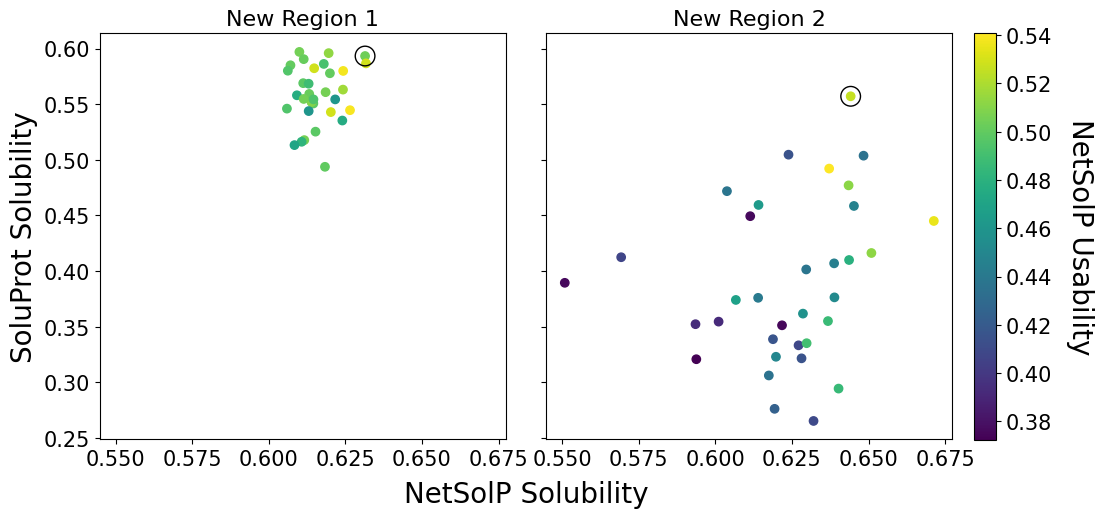

In [316]:

vmin = min(seq_selection_netsolp_r1.predicted_usability.min(), seq_selection_netsolp_r2.predicted_usability.min())
vmax = max(seq_selection_netsolp_r1.predicted_usability.max(), seq_selection_netsolp_r2.predicted_usability.max())

fig, ax = plt.subplots(1, 2,figsize=(11,6),sharex=True,sharey=True)

sc1 = ax[0].scatter(seq_selection_netsolp_r1.predicted_solubility,seq_selection_soluprot_r1.soluble,
              c=seq_selection_netsolp_r1.predicted_usability, vmin=vmin, vmax=vmax, cmap='viridis')
ax[0].scatter(seq_selection_netsolp_r1[seq_selection_netsolp_r1.index=='WP_139427101.1'].predicted_solubility,seq_selection_soluprot_r1[seq_selection_soluprot_r1.fa_id=='WP_139427101.1'].soluble,
              c='none', edgecolor='black', s=200, alpha=1, zorder=3, label='Selected')
ax[0].set_xlabel('NetSolP Solubility',fontsize=20)
ax[0].xaxis.set_label_coords(1.05, -0.1)
ax[0].set_ylabel('SoluProt Solubility',fontsize=20)
ax[0].set_title('New Region 1',fontsize=16)
ax[0].set_box_aspect(1)
ax[1].scatter(seq_selection_netsolp_r2.predicted_solubility,seq_selection_soluprot_r2.soluble,
              c=seq_selection_netsolp_r2.predicted_usability, vmin=vmin, vmax=vmax, cmap='viridis')
ax[1].scatter(seq_selection_netsolp_r2[seq_selection_netsolp_r2.index=='TMB50071.1'].predicted_solubility,seq_selection_soluprot_r2[seq_selection_soluprot_r2.fa_id=='TMB50071.1'].soluble,
              c='none', edgecolor='black', s=200, alpha=1, zorder=3, label='Selected')
#ax[1].set_xlabel('NetSolP Solubility',fontsize=20)
#ax[1].set_ylabel('SoluProt Solubility')
ax[1].set_title('New Region 2',fontsize=16)
ax[1].set_box_aspect(1)
ax[0].tick_params(labelsize=15)
ax[1].tick_params(labelsize=15)

cbar_ax = fig.add_axes([0.92, 0.155, 0.02, 0.679])
cbar = fig.colorbar(sc1, cax=cbar_ax)
cbar.set_label('NetSolP Usability', fontsize=20, rotation=270, labelpad=30)
cbar_ax.tick_params(labelsize=15)

fig.subplots_adjust(wspace=0.1)
#plt.tight_layout()
plt.show()

In [ ]:
seq_selection_netsolp_r1[(seq_selection_netsolp_r1.predicted_solubility>0.63)]

In [ ]:
seq_selection_soluprot_r1[seq_selection_soluprot_r1.fa_id.isin(['WP_139427101.1','WP_139735639.1'])]

In [ ]:
seq_selection_soluprot_r2[seq_selection_soluprot_r2.soluble>0.55]

In [ ]:
newreg_1_select = seq_selection_netsolp_r1[seq_selection_netsolp_r1.index=='WP_139427101.1']
newreg_2_select = seq_selection_netsolp_r2[seq_selection_netsolp_r2.index=='TMB50071.1']
with open(run.result+'/newreg_selected.fasta', 'w') as output_file:
    output_file.write(f">{newreg_1_select.index[0]}\n")
    output_file.write(f"{newreg_1_select.fasta[0]}\n")
    output_file.write(f">{newreg_2_select.index[0]}\n")
    output_file.write(f"{newreg_2_select.fasta[0]}\n")
output_file.close()